In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [2]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange, set_active_bound

BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"

# Load and set up model
model = read_sbml_model("../model/Rpom_05.xml")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

# Load condition data
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [22]:
# 2g0a, 0g6a, (2/3)g4a, (4/3)g2a 
glucose_uptakes = [30, 0, 10, 10]
acetate_uptakes = [0, 250, 300, 300,]
growth_rates = [0.3, 0.3, 0.25, 0.4]
initial_biomasses = [1.075e-6, 9e-6, 1.057e-5, 4.45e-6]

In [48]:
import parse

# for t, g in zip(data[list(data.keys())[0]]["mean"]["g_t"],
#                 data[list(data.keys())[0]]["mean"]["g_s"]):
#     print(f"{t}\t{g}")

# for t, a in zip(data[list(data.keys())[1]]["mean"]["a_t"],
#                 data[list(data.keys())[1]]["mean"]["a_s"]):
#     print(f"{t}\t{a}")

# for t, b in zip(data[list(data.keys())[0]]["mean"]["b_t"],
#                 data[list(data.keys())[0]]["mean"]["b_s"]):
#     # Use parse to convert exponential notation to *10^
#     if "e" in str(b):
#         p = parse.parse("{num}e{power}", str(b))
#         b_str = f"{p['num']}*10^{{{p['power']}}}"
#     else:
#         b_str = str(b)
#     print(f"{t}\t{b_str}")

for t, b in zip(data[list(data.keys())[1]]["mean"]["b_t"],
                data[list(data.keys())[1]]["mean"]["b_s"]):
    # Use parse to convert exponential notation to *10^
    if "e" in str(b):
        p = parse.parse("{num}e{power}", str(b))
        b_str = f"{p['num']}*10^{{{p['power']}}}"
    else:
        b_str = str(b)
    print(f"{t}\t{b_str}")

0.5	3.870000000000027*10^{-06}
1.0	2.150000000000026*10^{-06}
1.5	1.0033333333333423*10^{-06}
2.0	1.0033333333333423*10^{-06}
2.5	1.4333333333334142*10^{-07}
3.0	2.8666666666668284*10^{-07}
3.5	2.8666666666668284*10^{-07}
4.0	2.8666666666668284*10^{-07}
4.5	2.0066666666666846*10^{-06}
5.0	1.7773333333333362*10^{-05}
5.5	3.76966666666667*10^{-05}
6.0	4.988000000000004*10^{-05}
6.5	5.5900000000000044*10^{-05}
7.0	6.794000000000006*10^{-05}
7.5	7.482000000000006*10^{-05}
8.0	8.256000000000005*10^{-05}
8.5	9.718000000000007*10^{-05}
9.0	0.00010320000000000007
9.5	0.00011954000000000005
10.0	0.00013932000000000007
10.5	0.00016512000000000007
11.0	0.00018834000000000014
11.5	0.00021328000000000015
12.0	0.00024251999999999998
12.5	0.0002709
13.0	0.00030616000000000004
13.5	0.0003431400000000001
14.0	0.00038356000000000013
14.5	0.00043172000000000013
15.0	0.0004867600000000001
15.5	0.0005504000000000003
16.0	0.0006260800000000001
16.5	0.0007120800000000002
17.0	0.0008135600000000002
17.5	0.000

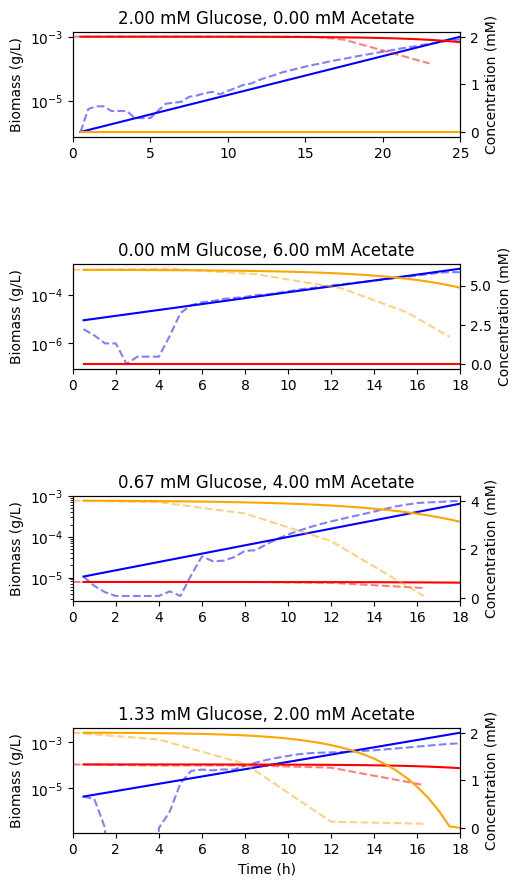

In [23]:
t_maxes = [25, 18, 18, 18]

# Plot data
fig, axs = plt.subplots(4, 1)

for i, (condition, condition_data) in enumerate(data.items()):
    g, a = [c.magnitude for c in condition]

    ax = axs[i]
    tmax = t_maxes[i]
    glucose_uptake = glucose_uptakes[i]
    acetate_uptake = acetate_uptakes[i]
    growth_rate = growth_rates[i]
    
    b_t = condition_data["mean"]["b_t"]
    b_t = b_t[b_t <= tmax]
    b_s = condition_data["mean"]["b_s"][:len(b_t)]
    g_t = condition_data["mean"]["g_t"]
    g_t = g_t[g_t <= tmax]
    g_s = condition_data["mean"]["g_s"][:len(g_t)]
    a_t = condition_data["mean"]["a_t"]
    a_t = a_t[a_t <= tmax]
    a_s = condition_data["mean"]["a_s"][:len(a_t)]

    # Integrate
    glucose_sim = [g]
    acetate_sim = [a]
    biomass_sim = [initial_biomasses[i]]

    for t1, t2 in zip(b_t, b_t[1:]):
        dt = t2 - t1

        # dB/dt = mu * B
        next_b = biomass_sim[-1] + growth_rate * biomass_sim[-1] * dt
        biomass_sim.append(next_b)

        # dN/dt = b * v_N
        next_g = glucose_sim[-1] - glucose_uptake * biomass_sim[-1] * dt
        glucose_sim.append(max(next_g, 0))
        next_a = acetate_sim[-1] - acetate_uptake * biomass_sim[-1] * dt
        acetate_sim.append(max(next_a, 0))

    # Plot
    ax.set_title(f"{g:.2f} mM Glucose, {a:.2f} mM Acetate")

    ax.plot(b_t,
            b_s,
            "b--",
            label="Biomass",
            alpha=0.5)
    ax.plot(b_t,
            biomass_sim,
            "b-",
            label="Biomass (sim)")
    ax.set_ylabel("Biomass (g/L)")

    ax2 = ax.twinx()
    ax2.plot(g_t,
             g_s,
             "r--",
             label="Glucose",
            alpha=0.5)
    ax2.plot(b_t,
             glucose_sim,
             "r-",
             label="Glucose (sim)")
    ax2.plot(a_t,
             a_s,
             color="orange",
             linestyle="--",
             label="Acetate",
            alpha=0.5)
    ax2.plot(b_t,
             acetate_sim,
             color="orange",
             label="Acetate (sim)")
    ax2.set_ylabel("Concentration (mM)")

    ax.set_xlim(0, tmax)
    ax2.set_xlim(0, tmax)
    
    ax.set_yscale("log")
    # ax2.set_yscale("log")


axs[-1].set_xlabel("Time (h)")
fig.tight_layout()
fig.set_size_inches(5, 10)

In [5]:
g_s

array([1.33333333, 1.31026377, 1.31374865, 1.2653481 , 0.90234509])

In [6]:
# # 2g0a, 0g6a, (2/3)g4a, (4/3)g2a 
glucose_uptakes = [10, 0, 10, 10]
acetate_uptakes = [0, 250, 300, 300,]
growth_rates = [0.3, 0.25, 0.25, 0.4]
initial_biomasses = [1e-5, 6e-5, 6.056e-5, 2.73125e-5]

100%|██████████| 2799/2799 [00:00<00:00, 17090.95it/s]


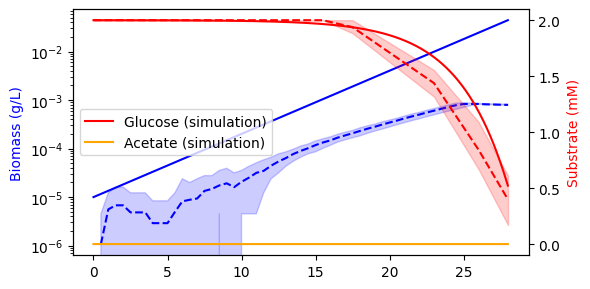

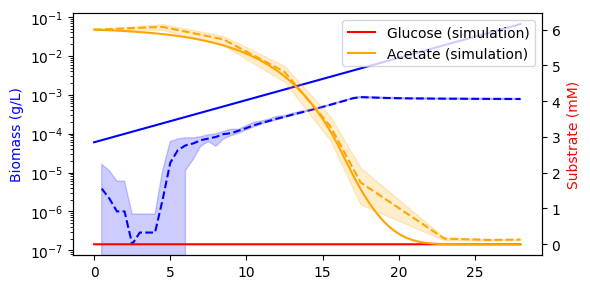

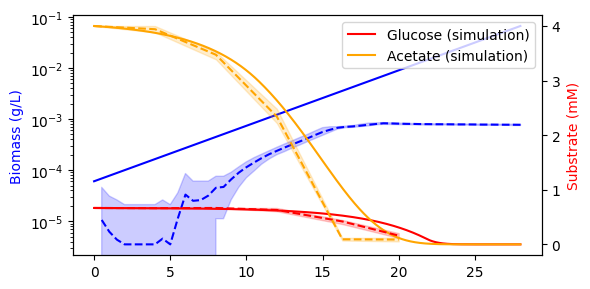

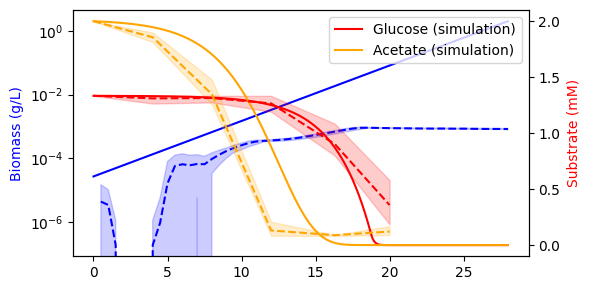

In [7]:
import warnings 
import os
from cue import plot_result
from cue2 import CUE_Experiment_2
from experiments.fast_dFBA import (ConstantBounds, dFBA, make_bge_listener,
                                   make_boundary_listener, make_cue_listener,
                                   make_growth_rate_listener,
                                   make_shadow_price_listener,
                                   plot_shadow_prices,
                                   evaluate_rates_sim)


# Monkey-patching run_condition to use evalue_rates_sim
def run_condition(self, condition, condition_data, save_data=True):
    initial, tmax, b_t, b, g_t, g_s, a_t, a_s = self.unpack_condition_data(
        condition, condition_data
    )
    initial_biomass, initial_glucose, initial_acetate = initial
    
    # Get glucose and acetate uptake rates, growth rate, override initial biomass
    glucose_uptake = condition_data["glucose_uptake"]
    acetate_uptake = condition_data["acetate_uptake"]
    growth_rate = condition_data["growth_rate"]
    initial_biomass = condition_data["initial_biomass"]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        t, y, l = evaluate_rates_sim(
            initial_biomass,
            [initial_glucose, initial_acetate],
            growth_rate,
            glucose_uptake,
            acetate_uptake,
            tmax,
            dt=0.01,
            integrator="runge_kutta",
        )

    return t, y, l

CUE_Experiment_2.run_condition = run_condition
cue = CUE_Experiment_2(model, BIOMASS_ID, ex_ace=ex_ace.id)
cue.conditions = data

# Add glucose and acetate uptake rates, growth rate, initial biomass to conditions
for i, (condition, condition_data) in enumerate(data.items()):
    g, a = [c.magnitude for c in condition]

    tmax = t_maxes[i]
    glucose_uptake = glucose_uptakes[i]
    acetate_uptake = acetate_uptakes[i]
    growth_rate = growth_rates[i]

    # Add keys for glucose and acetate uptake rates, growth rate, initial biomass
    cue.conditions[condition]["glucose_uptake"] = glucose_uptake
    cue.conditions[condition]["acetate_uptake"] = acetate_uptake
    cue.conditions[condition]["growth_rate"] = growth_rate
    cue.conditions[condition]["initial_biomass"] = initial_biomasses[i]

results = cue.run()

for condition, (t, y, l) in results.items():
    # Plot data
    initial_glucose, initial_acetate = condition
    condition_data = cue.conditions[condition]
    fig, (ax, _) = plot_result(t, y, condition_data, mass_units=False)
    ax.set_yscale("log")

    # Save figure
    fig.set_size_inches(6, 3)
    fig.tight_layout()
    fig.savefig(
        f"{model.id}_{initial_glucose.magnitude:.2f}mM_glucose_{initial_acetate.magnitude:.2f}mM_acetate_dFBA.png"
    )


In [8]:
np.log(2) / .25

2.772588722239781

Text(0, 0.5, 'Growth rate (1/h)')

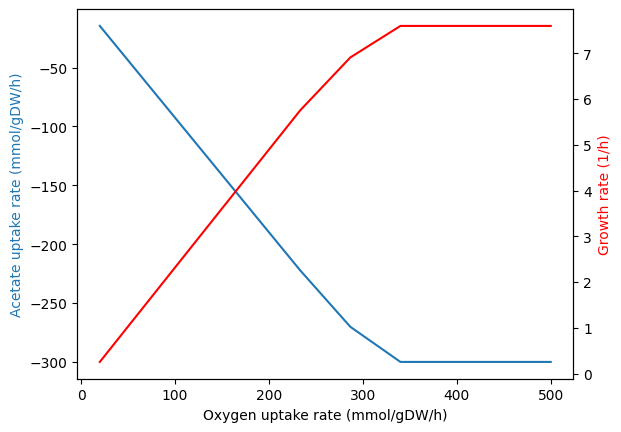

In [9]:
ex_o2 = model.reactions.get_by_id("EX_o2")
o2_bounds = np.linspace(-500, -20, 10)

acetate_uptake = []
mu = []
for o2_bound in o2_bounds:
    with model:
        ex_ace.bounds = (-300, 0)
        ex_o2.bounds = (o2_bound, 0)
        
        sol = model.optimize()
        acetate_uptake.append(sol.fluxes[ex_ace.id])
        mu.append(sol.objective_value)

acetate_uptake = np.array(acetate_uptake)
mu = np.array(mu)

fig, ax = plt.subplots()
ax.plot(-o2_bounds, acetate_uptake)
ax2 = ax.twinx()
ax2.plot(-o2_bounds, mu, color="red")

ax.set_xlabel("Oxygen uptake rate (mmol/gDW/h)")
ax.set_ylabel("Acetate uptake rate (mmol/gDW/h)", color="tab:blue")
ax2.set_ylabel("Growth rate (1/h)", color="red")
